In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
#% matplotlib inline
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from scipy.integrate import solve_ivp

class Lorenz(object):
    def __init__(self, sigma=10., beta=8 / 3., rho=28., **kwargs):
        super().__init__(**kwargs)

        self.sigma = sigma
        self.beta = beta
        self.rho = rho

    def __call__(self, t, x):
        """ x here is [x, y, z] """
        # x = tf.cast(x, tf.float64)

        dx_dt = self.sigma * (x[1] - x[0])
        dy_dt = x[0] * (self.rho - x[2]) - x[1]
        dz_dt = x[0] * x[1] - self.beta * x[2]

        dX_dt = tf.stack([dx_dt, dy_dt, dz_dt])
        return dX_dt

Jacobian定義

In [2]:
def jacobian(t, f, x):
    """ return jacobian matrix of f at x"""
    n = x.shape[-1].value
    fx = f(t, x)
    if x.shape[-1].value != fx.shape[-1].value:
        print('For calculating Jacobian matrix',
              'dimensions of f(x) and x must be the same')
        return

    return tf.concat([tf.gradients(fx[i], x) for i in range(0, n)], 0)

# 各変数、パラメータ、関数の定義

In [3]:
rho = tf.Variable(28.0, dtype=tf.float64,
                             name='rho')
sigma = tf.Variable(10.0, dtype=tf.float64,
                     name='sigma')
beta = tf.Variable(8.0/3.0, dtype=tf.float64,
                                    name='sigma')

f_lorenz = Lorenz(sigma=sigma, rho=rho, beta=beta)

# define a state variable x as Variable
x = tf.Variable([1,1,10], dtype=tf.float64, name='x') 
fx= f_lorenz(None,x)

# op for initialize x from outside of TF
x_init=  tf.placeholder(dtype=tf.float64, shape=(3), name='x_init')
init_x_op = tf.assign(x,x_init)

# 損失関数とオプティマイザ

In [4]:
loss = tf.math.reduce_sum( tf.math.square(fx))
opt = tf.train.GradientDescentOptimizer(1e-3)
train_op = opt.minimize(loss, var_list=[x])

動作チェック

In [6]:
# %% check
sess =  tf.Session()
sess.run(tf.initializers.global_variables())

print("x:",sess.run(x))
print("loss:",sess.run(loss))


sess.run(init_x_op, feed_dict={x_init:[5,5,5]})
print("x:",sess.run(x))
print("loss:",sess.run(loss))
# update x by train op
print("update x by train op")
sess.run(train_op)
print("x:",sess.run(x))
print("loss:",sess.run(loss))


x: [ 1.  1. 10.]
loss: 947.7777777777776
x: [5. 5. 5.]
loss: 12236.111111111111
update x by train op
x: [-0.17666691  5.10333334  6.16222228]
loss: 3168.619885118489


# 平衡点探索の関数

In [9]:
def find_equilibrium(sess,loss,x0,step_max=10000,eps=1e-12,printinfo=True):
    # set initial candidate x
    sess.run(init_x_op, feed_dict={x_init:x0})
    print('initial state')
    print("x:", sess.run(x))
    step = 0
    np.set_printoptions(precision=5)

    lo =sess.run(loss)
    while(lo > eps and step < step_max):
        step += 1
        _, xval, lo = sess.run((train_op, x, loss))
        if printinfo and step % 50 == 0:
          print("step:{:d} x:{:} sqnorm(f):{:.5g}".format(step, xval, lo))
    print('final result')
    print("step:{:d} x:{:} sqnorm(f):{:.5g}".format(step,xval,lo))
    sucsess = lo < eps
    return xval, lo, sucsess


３つの初期候補から探索してみる．

In [10]:

x_eq1, sqnorm1, suc = find_equilibrium(sess,loss,[3,5,21])

x_eq2, sqnorm2, suc = find_equilibrium(sess,loss,[-4,-3,20])

x_eq0, sqnorm0, suc = find_equilibrium(sess,loss,[2,2,5])

initial state
x: [ 3.  5. 21.]
step:50 x:[ 8.43694  8.45457 26.86746] sqnorm(f):1.7612
step:100 x:[ 8.48524  8.48525 26.99987] sqnorm(f):1.6352e-06
step:150 x:[ 8.48528  8.48528 27.     ] sqnorm(f):1.436e-12
final result
step:152 x:[ 8.48528  8.48528 27.     ] sqnorm(f):8.2207e-13
initial state
x: [-4. -3. 20.]
step:50 x:[-8.24324 -8.33641 26.40339] sqnorm(f):34.525
step:100 x:[-8.48506 -8.48514 26.99937] sqnorm(f):3.9507e-05
step:150 x:[-8.48528 -8.48528 27.     ] sqnorm(f):3.4703e-11
final result
step:163 x:[-8.48528 -8.48528 27.     ] sqnorm(f):9.2404e-13
initial state
x: [2. 2. 5.]
step:50 x:[2.02800e-04 1.02821e-03 2.56605e+00] sqnorm(f):48.185
step:100 x:[4.41482e-08 2.50015e-07 1.25376e+00] sqnorm(f):11.503
step:150 x:[7.91756e-12 4.72754e-11 6.12585e-01] sqnorm(f):2.7461
step:200 x:[1.30271e-15 7.98015e-15 2.99308e-01] sqnorm(f):0.65556
step:250 x:[2.05891e-19 1.27705e-18 1.46241e-01] sqnorm(f):0.1565
step:300 x:[3.19214e-23 1.99199e-22 7.14530e-02] sqnorm(f):0.037361
step:350 

# パラメータの変化に対する平衡点の変化の追跡と安定性の変化の追跡(分岐解析)

## 平衡点探索をクラスで実装し直す．

In [12]:
class Find_equilibrium:
    def __init__(self, f, eps=1e-12, infolevel=2):
        self.eps = eps
        self.infolevel = infolevel
        self.x = tf.Variable([1,1,10], dtype=tf.float64, name='x') # candidate of equilibrium
        self.fx= f(None,self.x)
        # squarenorm of f(x): sum_i{f_i(x)^2}
        self.loss = tf.math.reduce_sum( tf.math.square(self.fx))

        # op for initialize x from outside of TF
        self.x_init=  tf.placeholder(dtype=tf.float64, shape=(3), name='x_init')
        self.init_x_op = tf.assign(self.x,self.x_init)

        # optimizer

        opt = tf.train.GradientDescentOptimizer(1e-3)
        self.train_op = opt.minimize(self.loss, var_list=[self.x])

    def find(self, sess, x0, step_max=10000):
        sess.run(self.init_x_op, feed_dict={self.x_init: x0})
        if self.infolevel >= 1:
            print('initial state')
            print("x:", sess.run(self.x))
        step = 0
        np.set_printoptions(precision=5)

        lo =sess.run(self.loss)
        # gradient descent search
        while(lo > self.eps and step < step_max):
            step += 1
            _, xval, lo = sess.run((self.train_op, self.x, self.loss))
            if self.infolevel>=2 and step % 10 == 0:
                print("step:{:d} x:{:} sqnorm(f):{:.5g}".format(step, xval, lo))
        # show final results
        if self.infolevel >= 1:
            print('final result')
            print("step:{:d} x:{:} sqnorm(f):{:.5g}".format(step,xval,lo))

        # record results to member variable
        self.sucsess = lo < self.eps
        self.xeq = xval
        self.sqnorm = lo
        self.step = step
        return xval


動作確認

In [13]:
feq = Find_equilibrium(f_lorenz, eps=1e-12, infolevel=2)

feq.find(sess, np.array([5, 5, 20.0], dtype=np.float64), step_max=10000)

initial state
x: [ 5.  5. 20.]
step:10 x:[ 5.42217  6.43195 21.5525 ] sqnorm(f):1484.6
step:20 x:[ 6.77094  7.41857 23.695  ] sqnorm(f):760.48
step:30 x:[ 7.87191  8.11421 25.64057] sqnorm(f):165.99
step:40 x:[ 8.32552  8.38602 26.59135] sqnorm(f):16.445
step:50 x:[ 8.44647  8.46056 26.89276] sqnorm(f):1.1544
step:60 x:[ 8.47577  8.47917 26.97301] sqnorm(f):0.073405
step:70 x:[ 8.48293  8.48377 26.99328] sqnorm(f):0.004551
step:80 x:[ 8.4847   8.48491 26.99833] sqnorm(f):0.00028037
step:90 x:[ 8.48514  8.48519 26.99959] sqnorm(f):1.7245e-05
step:100 x:[ 8.48525  8.48526 26.9999 ] sqnorm(f):1.0603e-06
step:110 x:[ 8.48527  8.48528 26.99997] sqnorm(f):6.5188e-08
step:120 x:[ 8.48528  8.48528 26.99999] sqnorm(f):4.0076e-09
step:130 x:[ 8.48528  8.48528 27.     ] sqnorm(f):2.4638e-10
step:140 x:[ 8.48528  8.48528 27.     ] sqnorm(f):1.5147e-11
step:150 x:[ 8.48528  8.48528 27.     ] sqnorm(f):9.3118e-13
final result
step:150 x:[ 8.48528  8.48528 27.     ] sqnorm(f):9.3118e-13


array([ 8.48528,  8.48528, 27.     ])

## rho を変化させて平衡点の変化を確認

In [16]:
tf.reset_default_graph()

rho = tf.Variable(28.0, dtype=tf.float64,
                             name='rho')
sigma = tf.Variable(10.0, dtype=tf.float64,
                     name='sigma')
beta = tf.Variable(8.0/3.0, dtype=tf.float64,
                                    name='sigma')

# rho を変えるop
rho_as = tf.placeholder(shape=(),dtype=tf.float64)
assign_rho_op = tf.assign(rho,rho_as)


f_lorenz = Lorenz(sigma=sigma, rho=rho, beta=beta)

feq = Find_equilibrium(f_lorenz, eps=1e-12, infolevel=1)

Df = jacobian(None,f_lorenz,feq.x)

#initial guess
x0 = np.array([3.0,3.0,10])
# range of bifurcation parameter rho
rho_max = 30
rho_min = 2.0
rho_step = 0.5
rs = np.arange(rho_min, rho_max+rho_step,rho_step)

sess=tf.Session()
sess.run(tf.initializers.global_variables())

xeqs=[]
eigvals = []

for r in rs:
    sess.run(assign_rho_op, feed_dict={rho_as:r})  # assign rho value
    xeq = feq.find(sess,x0,step_max=10000)
    xeqs.append(xeq)

    # jacobian and eigenvalues of equiribrium
    df = sess.run(Df)
    eigval, eigvecs = np.linalg.eig(df)
    eigvals.append(eigval)
    x0 = xeq # set next starting point


xeqs = np.array(xeqs)
eigvals = np.array(eigvals)


initial state
x: [ 3.  3. 10.]
final result
step:6633 x:[1.63299 1.63299 1.     ] sqnorm(f):9.9672e-13
initial state
x: [1.63299 1.63299 1.     ]
final result
step:4008 x:[2.  2.  1.5] sqnorm(f):9.937e-13
initial state
x: [2.  2.  1.5]
final result
step:2616 x:[2.3094 2.3094 2.    ] sqnorm(f):9.9099e-13
initial state
x: [2.3094 2.3094 2.    ]
final result
step:1911 x:[2.58199 2.58199 2.5    ] sqnorm(f):9.9943e-13
initial state
x: [2.58199 2.58199 2.5    ]
final result
step:1493 x:[2.82843 2.82843 3.     ] sqnorm(f):9.8702e-13
initial state
x: [2.82843 2.82843 3.     ]
final result
step:1218 x:[3.05505 3.05505 3.5    ] sqnorm(f):9.8937e-13
initial state
x: [3.05505 3.05505 3.5    ]
final result
step:1025 x:[3.26599 3.26599 4.     ] sqnorm(f):9.8865e-13
initial state
x: [3.26599 3.26599 4.     ]
final result
step:883 x:[3.4641 3.4641 4.5   ] sqnorm(f):9.7661e-13
initial state
x: [3.4641 3.4641 4.5   ]
final result
step:774 x:[3.65148 3.65148 5.     ] sqnorm(f):9.7498e-13
initial state
x:

# 結果の図示

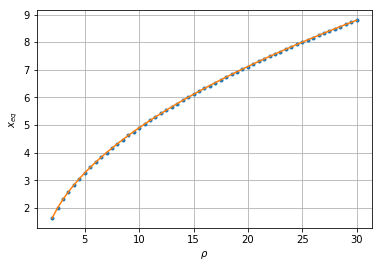

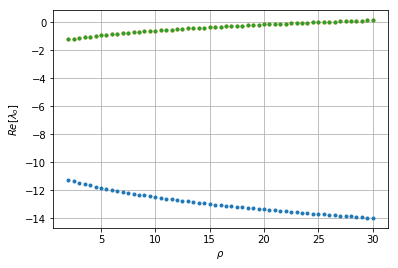

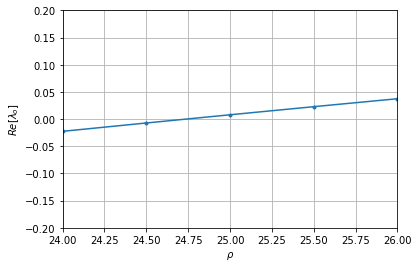

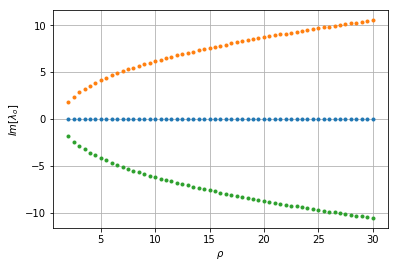

In [17]:
# %% figure
eqn_true= np.sqrt(8.0/3.0 * (rs-1)) # analytical solution of equiribrium (x value)
# x_eq as a function of rho
fig_eqb =plt.figure()
ax = fig_eqb.add_subplot(1, 1, 1)
ax.plot(rs, xeqs[:,0],'.')
ax.plot(rs,eqn_true)
ax.grid()
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$x_{eq}$')
plt.pause(0.01)



# real parts of eigenvalues of jacobian matrix at equiribrium
fig_eig_re =plt.figure()
ax = fig_eig_re.add_subplot(1, 1, 1)
ax.plot(rs, eigvals.real,'.')
# ax.plot(rs,eqn_true)
ax.grid()
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$Re[\lambda_o]$')
plt.pause(0.01)

# enlargement of the region
fig_eig_re2 =plt.figure()
ax = fig_eig_re2.add_subplot(1, 1, 1)
ax.plot(rs, eigvals.real[:,1],'.-')
ax.set_xlim(24,26)
ax.set_ylim(-0.2,0.2)
# ax.plot(rs,eqn_true)
ax.grid()
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$Re[\lambda_o]$')
plt.pause(0.01)

# true bifurcation point is rho = sigma(sigma+beta+3)/(sigma-beta-1)
rho_bifp_true = 10*(10+8.0/3.0+3)/(10-8.0/3.0-1)
rho_bifp_true
# imaginary parts of eigenvalues of jacobian matrix at equiribrium
fig_eig_im =plt.figure()
ax = fig_eig_im.add_subplot(1, 1, 1)
ax.plot(rs, eigvals.imag,'.')
# ax.plot(rs,eqn_true)
ax.grid()
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$Im[\lambda_o]$')
plt.pause(0.01)

# アトラクタ＋平衡点の図作成

In [18]:

def solve_lorenz(sess,fx,x0,ts):
    """ numerically solve lorenz equation
        using tensorflow operation fx
    """
    f_lorenz_tf = lambda t,xt: sess.run(fx, feed_dict={x_pf: xt})


    start_time = time.time()
    sol_lorenz = solve_ivp(fun=f_lorenz_tf,
                       t_span=[tstart, tend], y0=x0, t_eval=ts)
    integral_time_tf = time.time() - start_time
    print("processing time (TF): %.5f" % integral_time_tf)


    t_lo = sol_lorenz['t']
    x_lo = sol_lorenz['y']
    return x_lo,t_lo


x0 = np.array([1, 2, 3], dtype=np.float64)   # initial value

# integrating time
dt = 0.02
tstart = 0.0
tend = 100.0
ts = np.arange(tstart, tend+dt, dt)

x_pf = tf.placeholder(dtype=tf.float64, shape=(3), name='x_pf')
fx_pf = f_lorenz(None, x_pf)  # r.h.s. of ODE

sess = tf.Session()
sess.run(tf.initializers.global_variables())
# set rho to default value 28
sess.run(assign_rho_op, feed_dict={rho_as:28.0})  # assign rho value

x_lo, t_lo = solve_lorenz(sess, fx_pf, x0, ts)

processing time (TF): 3.20925


Text(0.5, 0.92, 'Lorenz Attractor')

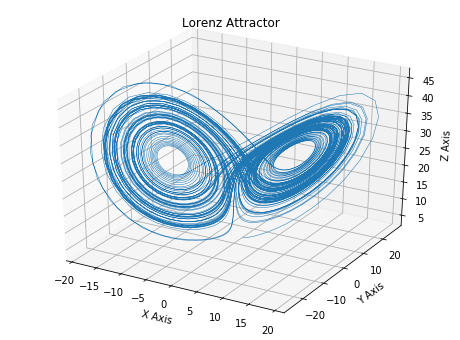

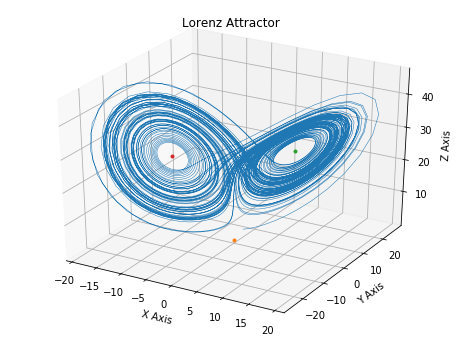

In [24]:
fig5 = plt.figure(figsize=(8,6))
ax = fig5.add_subplot(111,projection='3d')

ax.plot(x_lo[0], x_lo[1], x_lo[2], '-', lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

fig4 = plt.figure(figsize=(8,6))
ax4 = fig4.add_subplot(111,projection='3d')

ax4.plot(x_lo[0], x_lo[1], x_lo[2], '-', lw=0.5)
ax4.plot([x_eq0[0]],[x_eq0[1]],[x_eq0[2]],'.')
ax4.plot([x_eq1[0]],[x_eq1[1]],[x_eq1[2]],'.')
ax4.plot([x_eq2[0]],[x_eq2[1]],[x_eq2[2]],'.')

ax4.set_xlabel("X Axis")
ax4.set_ylabel("Y Axis")
ax4.set_zlabel("Z Axis")
ax4.set_title("Lorenz Attractor")

array([4.12557e-88, 2.58942e-87, 3.68290e-07])